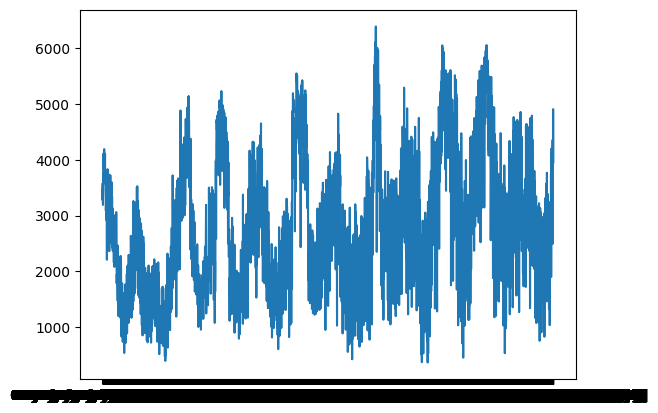

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import re

df = pd.read_csv('../data/full_data_2011-01-01_2022-11-26.csv', sep=',')

df = df.loc[[2]].drop(columns='Unnamed: 0').T
df.columns = ['energie']
df['The_date'] = df['energie']
df.head()

dict_month = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08','Sep': '09','Oct': '10','Nov': '11','Dec': '12'}

for i in range(len(df)):
    day = "".join(re.findall("\d", df.index[i].split(" ", 1)[0]))
    month = dict_month[df.index[i].split(" ")[1]]
    year = "".join(re.findall("\d", df.index[i].split(" ", 1)[1]))
    
    the_date = f'{day}-{month}-{year}'
        
    df['The_date'].iloc[i] = the_date
    
df['The_date'] = pd.to_datetime(df['The_date'])

plt.plot(df['energie'])

In [42]:
df_rain = pd.read_csv('../data/data_precipitation.csv', sep=';')
df_temp= pd.read_csv('../data/temperature_data.csv', sep=';')
df_temp.drop(columns=['Unnamed: 17'], inplace = True)
df = df[2557:-18]

In [43]:
rem_temp = df_temp['data']
rem_rain = df_rain['data']
df_temp['data'].drop(columns='data')
df_rain['data'].drop(columns='data')

df_rain['mean'] = df_rain.mean(axis=1)
df_temp['mean'] = df_temp.mean(axis=1)

/var/folders/9g/tq1twg9d6mq7h7qdcrf8krk40000gn/T/ipykernel_48853/410413502.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_rain['mean'] = df_rain.mean(axis=1)
/var/folders/9g/tq1twg9d6mq7h7qdcrf8krk40000gn/T/ipykernel_48853/410413502.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_temp['mean'] = df_temp.mean(axis=1)


In [48]:
df_train = df[:1600]
#temp_train = df_temp[:1600]
rain_train = df_rain[:1600]

df_test = df[1600:]
#temp_test = df_temp[1600:]
rain_test = df_rain[1600:]

In [45]:
from fbprophet import Prophet

model = Prophet(seasonality_mode='multiplicative')

model.fit(df_train)

forecast_test = model.predict(test)
forecast_test.head()

model.plot(forecast_test);

ModuleNotFoundError: No module named 'fbprophet'

In [49]:
df_train.reset_index(inplace = True)
rain_train.reset_index(inplace = True)

In [50]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(df_train['energie'], exog=rain_train['mean'], order=(2, 1, 1), seasonal_order=(0, 0, 2, 12))
sarima = sarima.fit(maxiter=75)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04572D+00    |proj g|=  1.03428D-01

At iterate    5    f=  8.02624D+00    |proj g|=  2.87102D-03

At iterate   10    f=  8.02621D+00    |proj g|=  1.36149D-04

At iterate   15    f=  8.02616D+00    |proj g|=  7.07320D-03

At iterate   20    f=  8.02375D+00    |proj g|=  2.79550D-02

At iterate   25    f=  8.02312D+00    |proj g|=  1.07749D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     31      1     0     0   

In [54]:
results = sarima.get_forecast(len(df_test), exog = rain_test["mean"], alpha=0.05)

In [55]:
forecast = results.predicted_mean
confidence_int = results.conf_int()

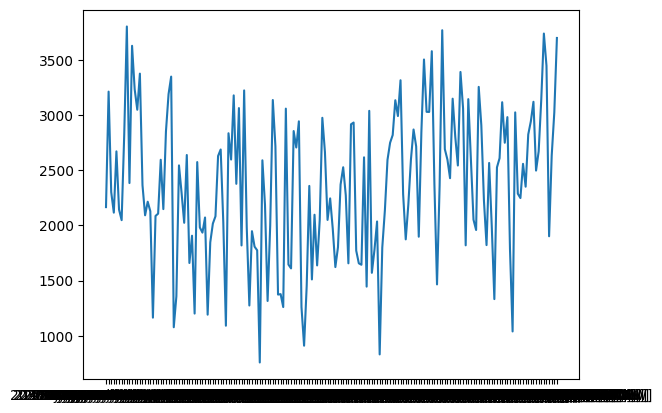

In [67]:
plt.plot(df_test['energie'])

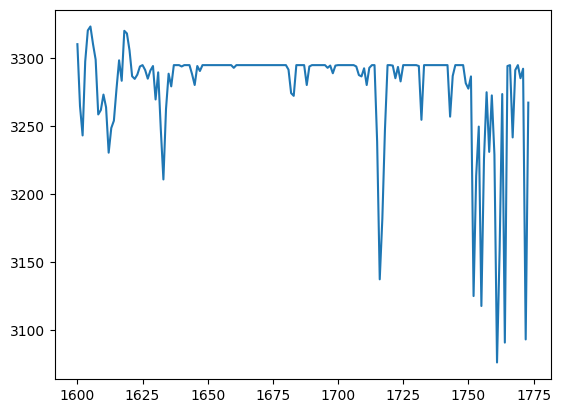

In [57]:
plt.plot(forecast)

In [74]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);


TypeError: unhashable type: 'numpy.ndarray'

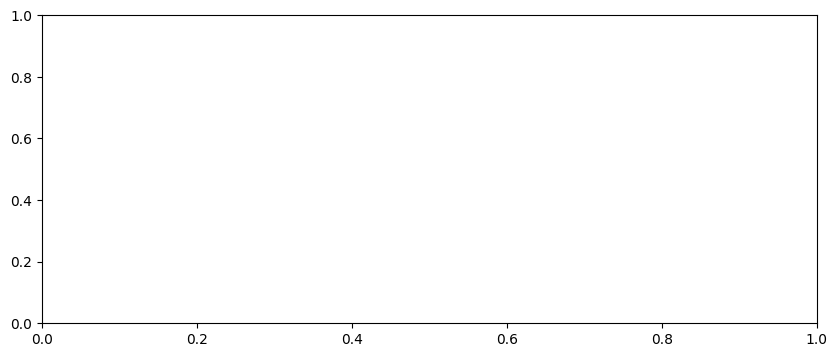

In [75]:
forecast_recons = pd.Series(forecast, index=df_test.index)
lower_recons = confidence_int['lower energie'].values
upper_recons = confidence_int['upper energie'].values

plot_forecast(forecast, df_train, df_test, upper = upper_recons, lower=lower_recons)